# First basic data understanding

## Imports

In [1]:
import pandas as pd
import json

## Data

In [6]:
!ls ../data/raw/data_set_phase1/

profiles.csv	test_queries.csv  train_plans.csv
test_plans.csv	train_clicks.csv  train_queries.csv


In [7]:
df_profiles = pd.read_csv("../data/raw/data_set_phase1/profiles.csv")

In [8]:
df_profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,115511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,129719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_train_clicks = pd.read_csv("../data/raw/data_set_phase1/train_clicks.csv")

In [10]:
df_train_clicks.head()

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2
3,2022975,2018-10-14 12:28:11,9
4,988425,2018-11-12 16:47:30,7


In [135]:
df_train_plans = pd.read_csv("../data/raw/data_set_phase1/train_plans.csv")

In [12]:
df_train_plans.head()

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."


In [13]:
df_train_plans.sample(50).to_csv("../data/processed/plans_sample.csv")

In [134]:
df_train_queries = pd.read_csv("../data/raw/data_set_phase1/train_queries.csv")

In [94]:
df_train_queries.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"



## Query records

Every time a user searches for a trip from one destination to another a record will be created


- Train set of user queries
- One record is one route search from a user
- Can be further split into query records, display records and click records
- Session ID is key to query, display plans and user clicks
- SID = Session ID
- PID = Profile ID
- Req_time = timestamp
- o = origin
- d = destination

In [77]:
def extract_Points_df(df, lat_column, long_column, crs={'init': 'epsg:4326'}):
    df_copy = df.copy()
    from shapely.geometry import Point
    geometry = [Point(xy) for xy in zip(df_copy[long_column], df_copy[lat_column])]
    Points = gpd.GeoDataFrame(df_copy, crs=crs, geometry=geometry)
    return Points


In [133]:
def preprocess_queries(df_raw):
    df=df_raw.copy()
    
    df[['o_long','o_lat']] = df.o.str.split(",", 1, expand=True).astype(float)
    df.drop("o", axis=1, inplace=True)
    
    df[['d_long','d_lat']] = df.d.str.split(",", 1, expand=True).astype(float)
    df.drop("d", axis=1, inplace=True)    
    return df
    

In [102]:
def calculate_distance(coords_1, coords_2):
    """
        Function to calculate distance in km between two coordinates
        coords_1: (lat, long)
        coords_2: (lat, long)
        returns: distance in km
    """
    from geopy.distance import distance

    return(distance(coords_1, coords_2).km)
    

In [136]:
df_train_queries.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"


In [137]:
df_train_queries.isna().sum()

sid              0
pid         163979
req_time         0
o                0
d                0
dtype: int64

In [138]:
print("{} % are na values from query records".format(\
                                                     df_train_queries.loc[df_train_queries.pid.isna()].shape[0]/len(df_train_queries)*100))

32.7958 % are na values from query records


In [139]:
df_train_queries.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"


In [140]:
df_queries_pp = preprocess_queries(df_train_queries)

In [141]:
df_queries_pp.dtypes

sid           int64
pid         float64
req_time     object
o_long      float64
o_lat       float64
d_long      float64
d_lat       float64
dtype: object

In [142]:
df_queries_pp.head()

,sid,pid,req_time,o_long,o_lat,d_long,d_lat
0,3000821,NaN,2018-11-02 17:54:30,116.29,39.97,116.32,39.96
1,3085857,210736.0,2018-11-16 10:53:10,116.39,39.84,116.33,39.79
2,2944522,NaN,2018-10-06 10:33:58,116.31,39.93,116.27,40.00
3,559931,202427.0,2018-11-23 14:54:11,116.27,39.88,116.39,39.90
4,2819352,172251.0,2018-10-30 11:48:41,116.34,39.96,116.37,39.86


In [143]:
df_queries_pp = df_queries_pp.assign(distance_query = (df_queries_pp.apply(lambda x: calculate_distance([x.o_lat, x.o_long], 
                                                                                  [x.d_lat, x.d_long]),
                                                    axis=1)))

In [144]:
df_queries_pp.head()

,sid,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query
0,3000821,NaN,2018-11-02 17:54:30,116.29,39.97,116.32,39.96,2.793287
1,3085857,210736.0,2018-11-16 10:53:10,116.39,39.84,116.33,39.79,7.563924
2,2944522,NaN,2018-10-06 10:33:58,116.31,39.93,116.27,40.00,8.490532
3,559931,202427.0,2018-11-23 14:54:11,116.27,39.88,116.39,39.90,10.501168
4,2819352,172251.0,2018-10-30 11:48:41,116.34,39.96,116.37,39.86,11.395753


In [152]:
gdf_origin = extract_Points_df(df_queries_pp, lat_column="o_lat", long_column="o_long")

In [155]:
gdf_origin.head()

,sid,pid,req_time,o_lat,o_long,d_lat,d_long,geometry
0,3000821,NaN,2018-11-02 17:54:30,116.29,39.97,116.32,39.96,POINT (39.97 116.29)
1,3085857,210736.0,2018-11-16 10:53:10,116.39,39.84,116.33,39.79,POINT (39.84 116.39)
2,2944522,NaN,2018-10-06 10:33:58,116.31,39.93,116.27,40.00,POINT (39.93 116.31)
3,559931,202427.0,2018-11-23 14:54:11,116.27,39.88,116.39,39.90,POINT (39.88 116.27)
4,2819352,172251.0,2018-10-30 11:48:41,116.34,39.96,116.37,39.86,POINT (39.96 116.34)


In [154]:
gdf_destination = extract_Points_df(df_queries_pp, lat_column="d_lat", long_column="d_long")

In [156]:
gdf_destination.head()

,sid,pid,req_time,o_lat,o_long,d_lat,d_long,geometry
0,3000821,NaN,2018-11-02 17:54:30,116.29,39.97,116.32,39.96,POINT (39.96 116.32)
1,3085857,210736.0,2018-11-16 10:53:10,116.39,39.84,116.33,39.79,POINT (39.79 116.33)
2,2944522,NaN,2018-10-06 10:33:58,116.31,39.93,116.27,40.00,POINT (40 116.27)
3,559931,202427.0,2018-11-23 14:54:11,116.27,39.88,116.39,39.90,POINT (39.9 116.39)
4,2819352,172251.0,2018-10-30 11:48:41,116.34,39.96,116.37,39.86,POINT (39.86 116.37)


In [38]:
# Import shapefile
import geopandas as gpd
beijing_shape = gpd.read_file("../data/external/Beijing_shape_files/shape/roads.shp")

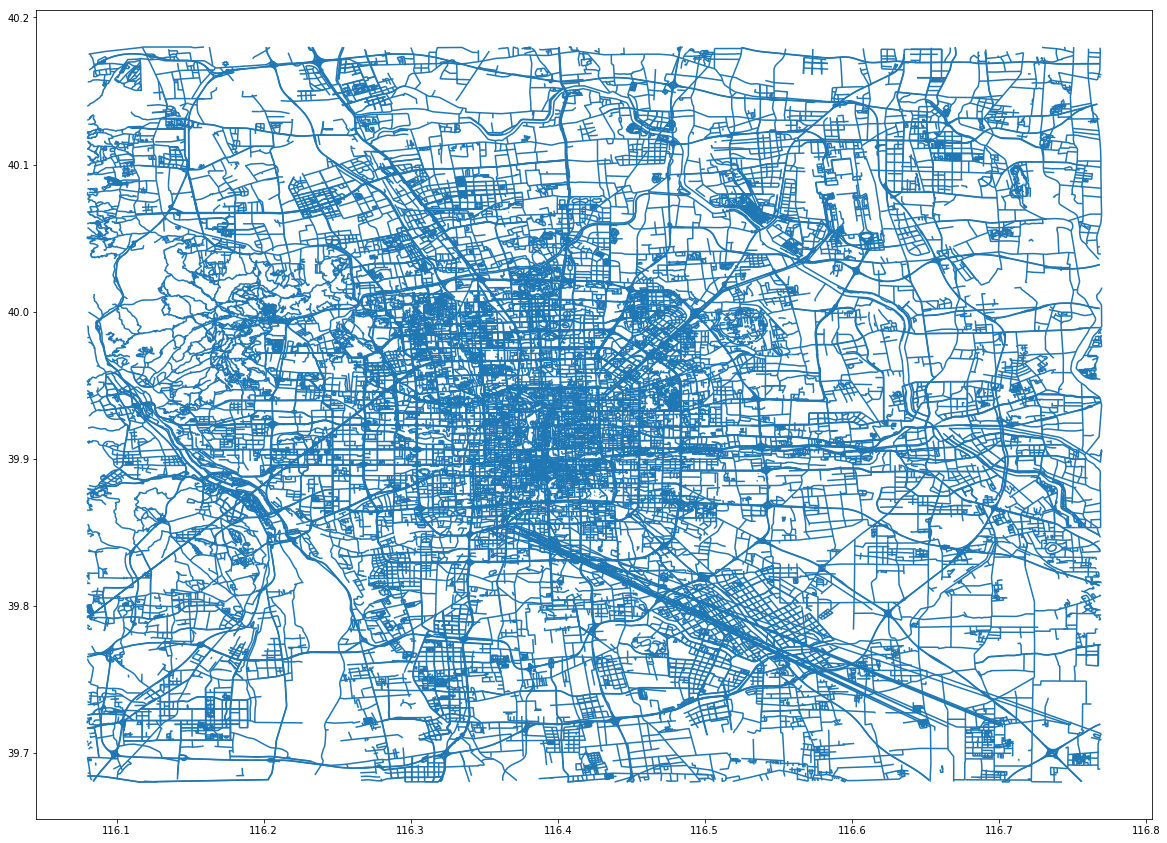

In [41]:
ax_shp = beijing_shape.plot(figsize=(20,20))

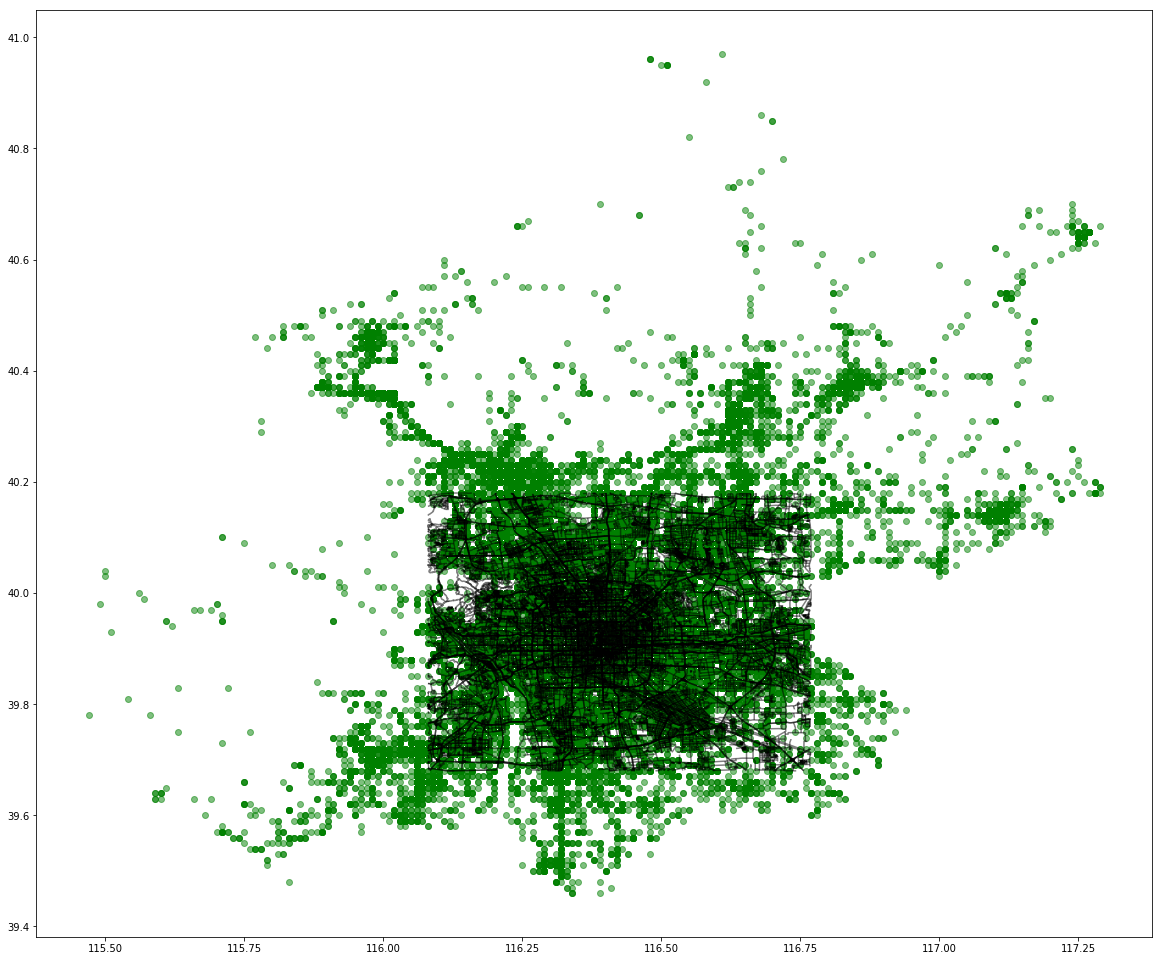

In [164]:
# Plot which shows Beijing and where the queries come from. Just ORIGIN! 

fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(df_queries_pp.o_lat, df_queries_pp.o_long, color="green", alpha=0.5);
ax_shp = beijing_shape.plot(facecolor="none", alpha=0.5, ax=ax, edgecolor='black');

## Display Record


- Session ID. Join somehow with clicks and queries? Feature query and plan was executed
- plan_time: timestamp
- plans: List of suggested routes with features:
        - distance in meters
        - ETA in seconds
        - estimated price in RMB cent
        - display rank on the display

I want to have a dataframe like that:

| sid | timestamp | distance | eta | price | transport_mode |
|------|------|------|------|------|------|
| 1709112 | 2018-11-04 11:45:04 | 32303 | 5087 | 600 | 1 |
| 1709112 | 2018-11-04 11:45:04 | 3203 | 50687 | 500 | 2 |
| 1709112 | 2018-11-04 11:45:04 | 3303 | 50857 | 6100000 | 3 |
| 1709112 | 2018-11-04 11:45:04 | 320303 | 50587 | 66000 | 5 |
| 1709112 | 2018-11-04 11:45:04 | 3232303 | 200 | 15 | 11 |

In [16]:
df_train_plans.head()

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."


In [18]:
def construct_df_plans(df):
    """
        This function constructs a DataFrame with all columns which are included in plans.
        df: DataFrame with columns: sid, plan_time, plans
        returns: DataFrame with columns: sid, plan_time, distance, eta, price, transport_mode, display_order
        
        If price is empty -1 will be entered! 
    """
    import json
    from tqdm import tqdm_notebook
    df_plan_unstacked = pd.DataFrame(columns=["sid", "plan_time", "distance", "eta", "price", "transport_mode", "display_order"])
    for i, plan in tqdm_notebook(enumerate(df['plans'].values)):
        try:
            cur_plan_list = json.loads(plan)
            if len(cur_plan_list) != 0:
                df_json = pd.DataFrame(cur_plan_list)
                # Add SID
                df_json = df_json.assign(sid = df.iloc[i,0])
                # Add plan_time
                df_json = df_json.assign(plan_time = df.iloc[i,1])

                df_plan_unstacked = df_plan_unstacked.append(df_json, sort=False)
        except:
            print("error")

    df_plan_unstacked["display_order"] = df_plan_unstacked.index
    df_plan_unstacked["price"] = pd.to_numeric(df_plan_unstacked["price"])
    df_plan_unstacked["price"] = df_plan_unstacked.price.fillna(-1)
    return df_plan_unstacked
        
    


In [24]:
%%time
sample = df_train_plans.sample(10000)
df_plan_unstacked = construct_df_plans(sample)


CPU times: user 2min 25s, sys: 752 ms, total: 2min 25s
Wall time: 2min 25s


In [25]:
df_plan_unstacked.shape

(46333, 7)

In [116]:
df_plan_unstacked.rename({"distance":"distance_displayed"}, axis=1, inplace=True)

In [117]:
df_plan_unstacked.head()

,sid,plan_time,distance_displayed,eta,price,transport_mode,display_order
0,3172723,2018-11-21 17:10:46,3973,2166,200.0,1,0
1,3172723,2018-11-21 17:10:46,3643,1099,-1.0,6,1
2,3172723,2018-11-21 17:10:46,5978,1551,-1.0,3,2
3,3172723,2018-11-21 17:10:46,5978,1731,2600.0,4,3
4,3172723,2018-11-21 17:10:46,3937,2449,200.0,1,4


## Clicks

- User feedback of different recommendation i.e. user clicks on specific route displayet to him
- sid = Session ID
- click_time = timestamp
- click_mode = Clicked transport mode -> Target for now?

In [63]:
df_train_clicks.head()

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2
3,2022975,2018-10-14 12:28:11,9
4,988425,2018-11-12 16:47:30,7


In [64]:
df_train_clicks.isna().sum()

sid           0
click_time    0
click_mode    0
dtype: int64

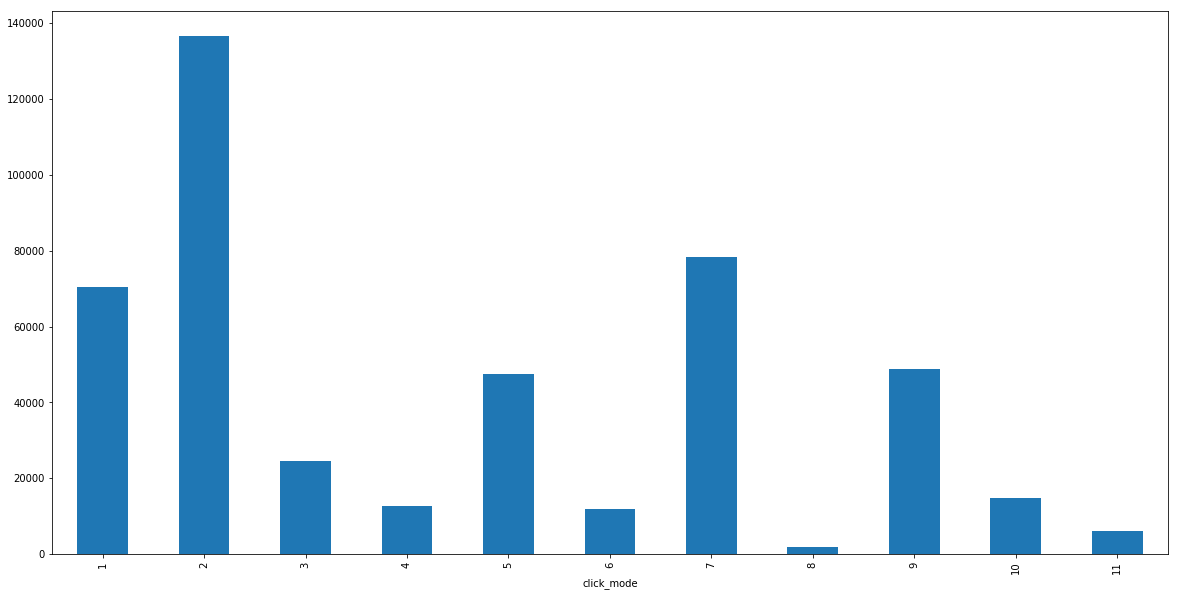

In [68]:
df_train_clicks.groupby("click_mode").count()["sid"].plot(kind="bar", figsize=(20,10));

## Join Datasets

In [2]:
import pandas as pd 
import numpy as np

In [3]:
df = pd.read_pickle("../data/processed/df_processed.pickle")

In [4]:
df.shape

(2101060, 15)

In [5]:
df.head()

,sid,click_time,click_mode,distance_plan,eta,price,transport_mode,plan_time,pid,req_time,o_long,o_lat,d_long,d_lat,distance_query
0,2848914,2018-11-17 18:42:17,1,53156,6456,700.0,1,2018-11-17 12:56:15,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,43.656570
1,2848914,2018-11-17 18:42:17,1,48112,3535,700.0,3,2018-11-17 12:56:15,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,43.656570
2,2848914,2018-11-17 18:42:17,1,48112,3655,16500.0,4,2018-11-17 12:56:15,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,43.656570
3,2848914,2018-11-17 18:42:17,1,51641,8871,1200.0,1,2018-11-17 12:56:15,101804.0,2018-11-17 12:56:15,116.36,40.07,116.00,40.35,43.656570
4,2629085,2018-10-12 16:28:13,3,13207,2790,400.0,9,2018-10-12 16:27:55,203797.0,2018-10-12 16:27:55,116.35,40.08,116.33,40.03,5.808139


In [6]:
df_X = df[["sid", "distance_plan", "eta", "price", "distance_query", "click_mode"]]

In [7]:
df_X.head()

,sid,distance_plan,eta,price,distance_query,click_mode
0,2848914,53156,6456,700.0,43.656570,1
1,2848914,48112,3535,700.0,43.656570,1
2,2848914,48112,3655,16500.0,43.656570,1
3,2848914,51641,8871,1200.0,43.656570,1
4,2629085,13207,2790,400.0,5.808139,3


In [8]:
def test_train_split_df(df_r, test_percentage=0.25):
    import numpy as np
    df = df_r.copy()
    
    msk = np.random.rand(len(df)) < (1-test_percentage)
    
    train = df[msk]
    test = df[~msk]
    
    
    return train, test
    

In [9]:
def create_query_file(df_r):
    df=df_r.copy()
    
    df = df.sort_values("sid")
    
    df = df.reset_index(drop=True)
    
    df = df.assign(row = df.index)
    
    df.row = df.row+1
    
    sid_rows=pd.DataFrame(df.groupby("sid").last()["row"])
    
    sid_diff = sid_rows.assign(difference = sid_rows.diff())
    
    sid_diff.iloc[0,1] = sid_diff.iloc[0,0]
    
    query = sid_diff.difference.values
    
    return query

In [10]:
train, test = test_train_split_df(df_X)

In [11]:
len(train) + len(test) == len(df_X)

True

In [12]:
query = create_query_file(train)

In [13]:
query.sum()

1575549.0

In [14]:
len(train)

1575549

In [15]:
train.head()

,sid,distance_plan,eta,price,distance_query,click_mode
0,2848914,53156,6456,700.0,43.656570,1
1,2848914,48112,3535,700.0,43.656570,1
2,2848914,48112,3655,16500.0,43.656570,1
3,2848914,51641,8871,1200.0,43.656570,1
4,2629085,13207,2790,400.0,5.808139,3


In [16]:
train = train.sort_values("sid")

In [17]:
x_train = train.drop(["sid", "click_mode"], axis=1).values
y_train = train.loc[:,"click_mode"].values

In [18]:
x_test = test.drop(["sid", "click_mode"], axis=1).values
y_test = test.loc[:,"click_mode"].values

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1575549, 4)
(1575549,)
(525511, 4)
(525511,)


In [26]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [72]:
y_train.dtype

dtype('int64')

In [78]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train,
                      feature_name=list(train.drop(["sid", "click_mode"], axis=1)),
                      group=query)

params = {}
params['objective'] = 'lambdarank'
params['metric'] = 'map'

clf = lgb.train(params, d_train, 100)

y_preds = clf.predict(x_test)
y_preds.min()

0.0

In [80]:
y_preds.min()

0.0

In [69]:
y_preds.shape

(525511,)

In [52]:
x_test.shape

(525511, 4)

In [53]:
y_preds.shape

(525511,)

In [95]:
def f1_weighted(labels,preds):
    from sklearn.metrics import f1_score
    print(preds.shape)
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True


In [100]:
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=100, objective='multiclass',subsample=0.8, colsample_bytree=0.8, 
    subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="multiclass",n_jobs=-1)
eval_set = [(x_test, y_test)]
lgb_model.fit(x_train, y_train, verbose=10)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='multiclass', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

In [118]:
ser=pd.Series(y_preds)

In [130]:
np.array(test.sid.values).transpose()

array([2629085,  602598,  602598, ..., 2429419, 2429419, 1240915])

In [131]:
np.array(test.sid.values).transpose()

array([2629085,  602598,  602598, ..., 2429419, 2429419, 1240915])

In [125]:
y_preds.shape

(525511,)

In [133]:
pd.DataFrame([np.array(test.sid.values).transpose(), 
              np.array(test.sid.values).transpose()])

,0,1,2,3,4,5,6,7,8,9,...,525501,525502,525503,525504,525505,525506,525507,525508,525509,525510
0,2629085,602598,602598,602598,988425,64208,64208,2318006,2318006,2318006,...,1040270,2591653,717794,3042223,3113677,2343459,2343459,2429419,2429419,1240915
1,2629085,602598,602598,602598,988425,64208,64208,2318006,2318006,2318006,...,1040270,2591653,717794,3042223,3113677,2343459,2343459,2429419,2429419,1240915


In [101]:
y_preds = lgb_model.predict(x_test)

In [105]:
y_preds.min()

1

In [110]:
from sklearn.metrics import f1_score
f1_score(y_test, y_preds, average='weighted')

/home/sandro/anaconda3/envs/kdd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.36617035575416845

In [111]:
y_preds

array([2, 1, 2, ..., 2, 2, 5])

In [112]:
y_test

array([3, 2, 2, ..., 1, 1, 5])

In [86]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

params = {}
params['objective'] = 'multiclass'
params['metric'] = 'binary_logloss'

clf = lgb.train(params, d_train, 100)

LightGBMError: Number of classes should be specified and greater than 1 for multiclass training

In [83]:
y_preds = clf.predict(x_test)

SyntaxError: invalid syntax (<ipython-input-85-97f0710af97c>, line 1)

In [57]:
ranker = lgb.LGBMRanker()
ranker.fit(x_train, y_train, group=query)

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
      importance_type='split', learning_rate=0.1, max_depth=-1,
      min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
      n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
      random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
      subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

AttributeError: 'numpy.ndarray' object has no attribute 'nunique'

In [63]:
train

,sid,distance_plan,eta,price,distance_query,click_mode
1714842,10,49758,6878,5500.0,37.542362,1
1714841,10,47429,4604,14100.0,37.542362,1
1714840,10,47429,4604,700.0,37.542362,1
1714844,10,48995,7396,3200.0,37.542362,1
1897612,21,7667,929,700.0,5.421446,2
1897613,21,7667,1229,2100.0,5.421446,2
1657107,25,3898,669,1300.0,2.379754,1
1657108,25,3521,1063,700.0,2.379754,1
1657110,25,2714,2434,700.0,2.379754,1
1657106,25,3898,429,700.0,2.379754,1


In [58]:
ranker.predict(x_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:

lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,categorical_feature=cate_feature, verbose=10, early_stopping_rounds=100)

In [32]:
y_preds = clf.predict(x_test)

0.9999999999999989